In [1]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%matplotlib inline

In [2]:
mb_size = 64
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

train_data = torchvision.datasets.MNIST('/home/davidpqc1231/GAN/Paper', download=True, transform=transform, train = True)
train_loader = DataLoader(train_data, shuffle=True, batch_size=mb_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


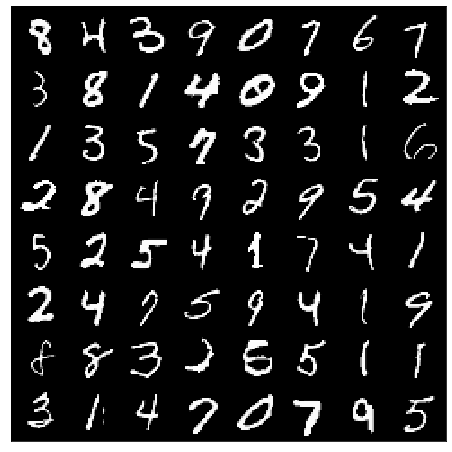

torch.Size([64, 1, 28, 28])


In [3]:
dataiter = iter(train_loader)
imgs, labels = dataiter.next()

def imshow(imgs):
    """ Visualizing images """
    # make_grid will make a grid out of images
    imgs = torchvision.utils.make_grid(imgs)
    
    # transfoming tensors to numpy arrays
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

imshow(imgs)

print(imgs.size())

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [5]:
def xavier_init(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [6]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model1 = nn.Sequential(
            nn.Linear(100,128*7*7),
            nn.ReLU()
        )
            
        self.model2 = nn.Sequential( 
            nn.ConvTranspose2d(in_channels=128,out_channels=64, 
                               kernel_size=2,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=64,out_channels=1, 
                               kernel_size=2,stride=2),
            nn.Tanh()
        )
             
        self.model1.apply(xavier_init)
        self.model2.apply(xavier_init)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.model1(x)
        y_ = y_.view(y_.size(0), 128, 7, 7)
        y_ = self.model2(y_)
        return y_
    
test1 = Gen().to(DEVICE)
print(test1)

Gen(
  (model1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
  )
  (model2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (4): Tanh()
  )
)


In [7]:
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=64,
                      kernel_size=3,stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64,out_channels=16,
                      kernel_size=3,stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(kernel_size=2,stride=1)
        )
        
        self.model2 = nn.Sequential(
            nn.Linear(16*5*5,1),
            nn.Sigmoid()
        )
            
        self.model1.apply(xavier_init)
        self.model2.apply(xavier_init)
    
    def forward(self, x):
        y_ = self.model1(x)
        y_ = y_.view(y_.size(0),-1)
        y_ = self.model2(y_)
        return y_
    
test2 = Dis().to(DEVICE)
print(test2)

Dis(
  (model1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (model2): Sequential(
    (0): Linear(in_features=400, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [8]:
# test 
z = torch.randn(64,100).to(DEVICE)

print(test1(z).shape)
print(test2(test1(z)).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1])


In [9]:
criterion = nn.BCELoss()
G = Gen().to(DEVICE)
D = Dis().to(DEVICE)

In [10]:
G_opt = opt.Adam(G.parameters(), lr=0.0001, betas=(0., 0.9))
D_opt = opt.Adam(D.parameters(), lr=0.0001, betas=(0., 0.9))

In [11]:
G_losses = []
D_losses = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:0,   G_loss:-0.08955973386764526,   D_loss:7.433071613311768


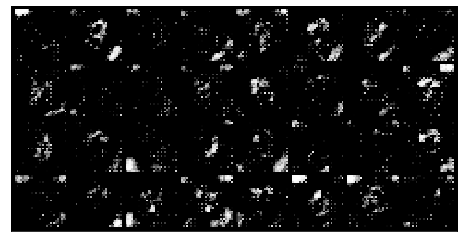

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1,   G_loss:-0.1873059868812561,   D_loss:8.769941329956055


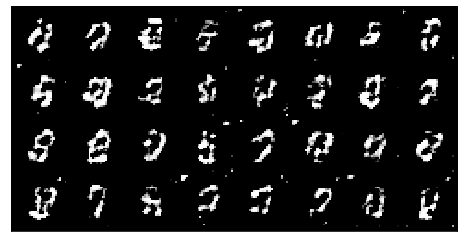

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2,   G_loss:-0.37890875339508057,   D_loss:9.359101295471191


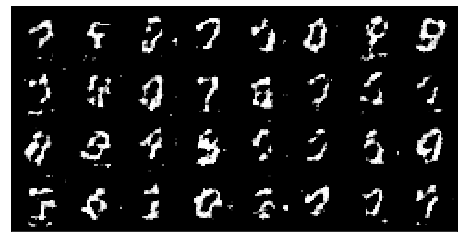

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3,   G_loss:-0.4401628375053406,   D_loss:9.391197204589844


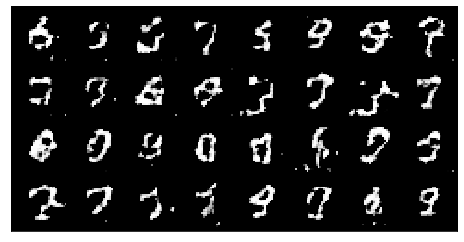

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4,   G_loss:-0.31805872917175293,   D_loss:9.330881118774414


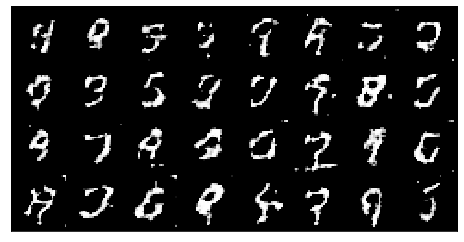

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5,   G_loss:-0.5323855876922607,   D_loss:9.289584159851074


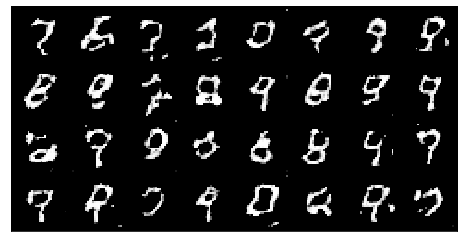

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6,   G_loss:-0.23088499903678894,   D_loss:9.224115371704102


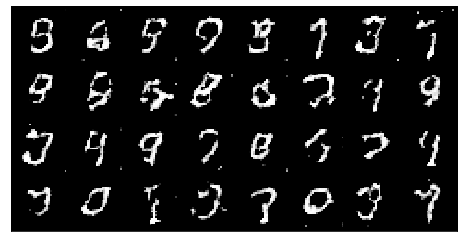

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7,   G_loss:-0.2377745360136032,   D_loss:9.439033508300781


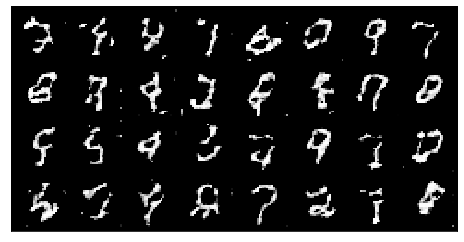

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8,   G_loss:-0.5027066469192505,   D_loss:9.426224708557129


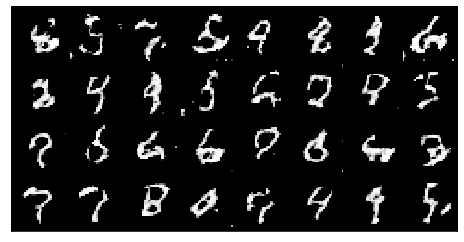

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9,   G_loss:-0.3929610252380371,   D_loss:9.381589889526367


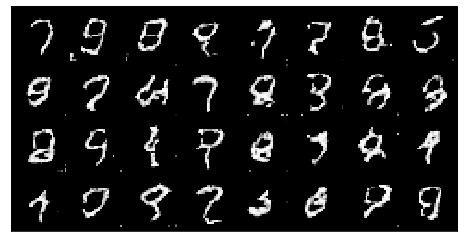

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10,   G_loss:-0.15172335505485535,   D_loss:9.955643653869629


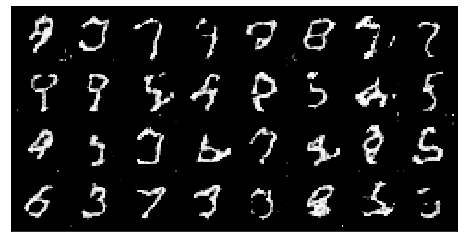

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11,   G_loss:-0.3661845624446869,   D_loss:9.612517356872559


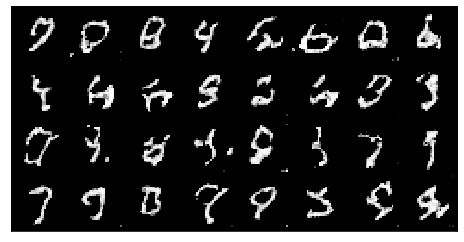

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12,   G_loss:-0.12267136573791504,   D_loss:9.631214141845703


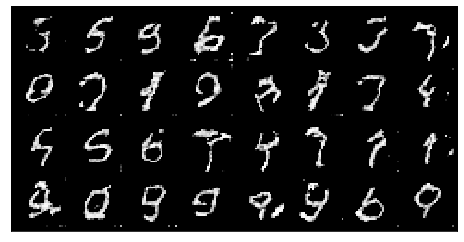

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13,   G_loss:-0.26141154766082764,   D_loss:9.708853721618652


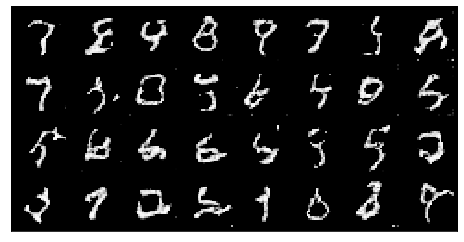

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:14,   G_loss:-0.46341389417648315,   D_loss:9.690489768981934


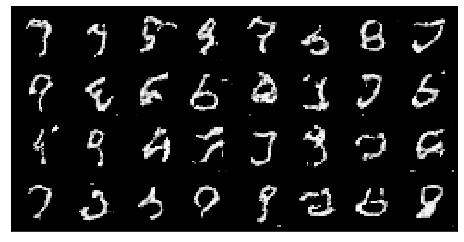

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:15,   G_loss:-0.6646723747253418,   D_loss:9.747182846069336


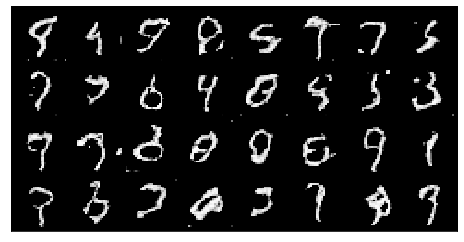

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:16,   G_loss:-0.4217798113822937,   D_loss:9.624921798706055


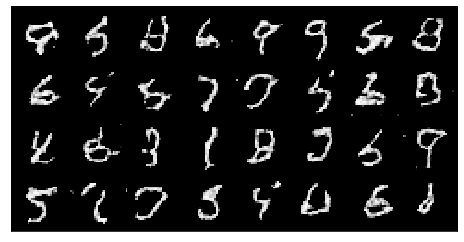

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:17,   G_loss:-0.3197619915008545,   D_loss:9.758631706237793


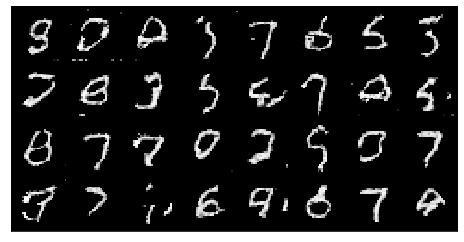

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:18,   G_loss:-0.07386298477649689,   D_loss:9.557942390441895


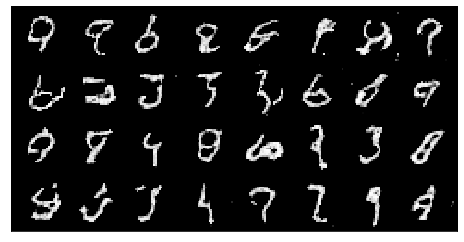

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:19,   G_loss:-0.646392822265625,   D_loss:9.77077579498291


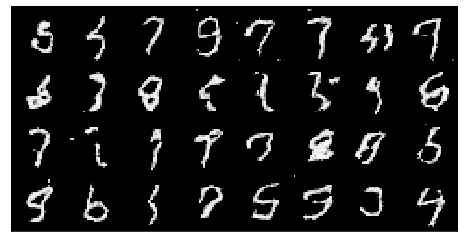

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:20,   G_loss:-0.20218510925769806,   D_loss:9.626120567321777


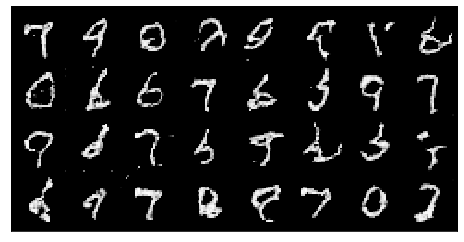

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:21,   G_loss:-0.2696772515773773,   D_loss:9.7078218460083


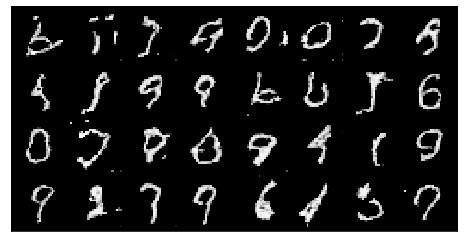

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:22,   G_loss:-0.4315847158432007,   D_loss:9.683022499084473


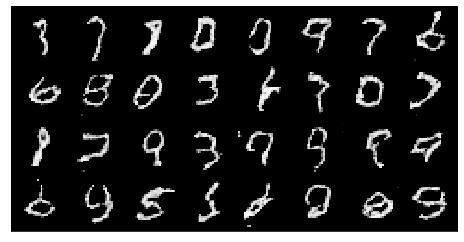

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:23,   G_loss:-0.4533712863922119,   D_loss:9.500204086303711


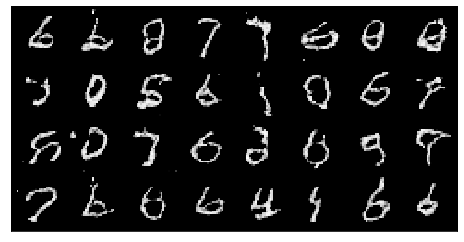

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:24,   G_loss:-0.1742371767759323,   D_loss:9.73971939086914


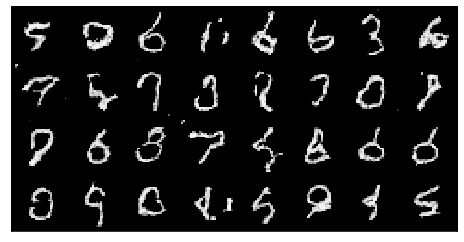

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:25,   G_loss:-0.2957766652107239,   D_loss:9.670974731445312


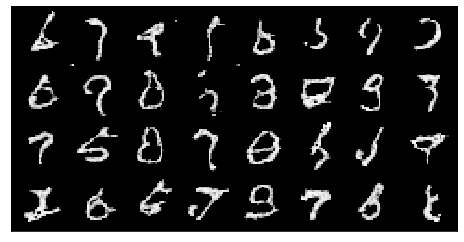

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:26,   G_loss:-0.6630710363388062,   D_loss:9.785869598388672


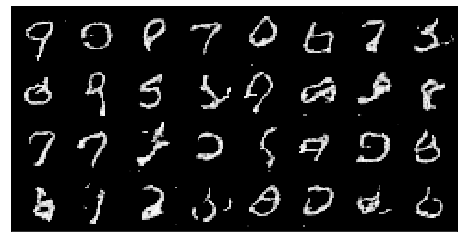

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:27,   G_loss:-0.23475804924964905,   D_loss:9.664365768432617


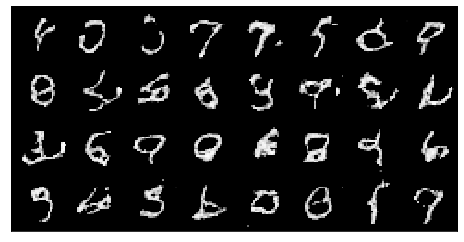

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:28,   G_loss:-0.39115428924560547,   D_loss:9.682185173034668


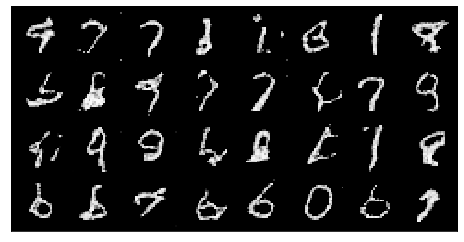

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:29,   G_loss:-0.40932220220565796,   D_loss:9.763509750366211


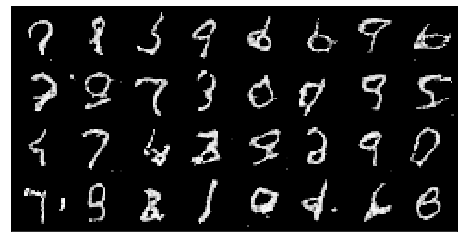

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:30,   G_loss:-0.6563944816589355,   D_loss:9.735577583312988


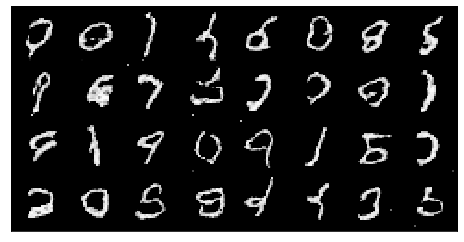

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:31,   G_loss:-0.5067945122718811,   D_loss:9.771140098571777


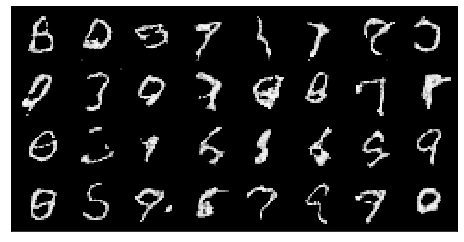

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:32,   G_loss:-0.5014745593070984,   D_loss:9.70382022857666


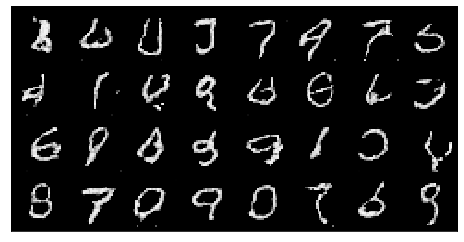

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:33,   G_loss:-0.33345383405685425,   D_loss:9.686392784118652


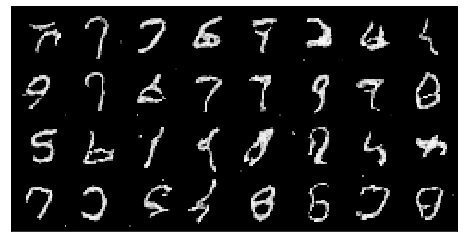

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:34,   G_loss:-0.2996271252632141,   D_loss:9.883206367492676


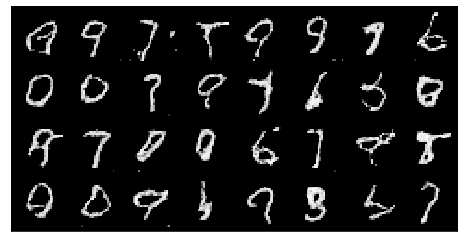

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:35,   G_loss:-0.6130581498146057,   D_loss:9.894454956054688


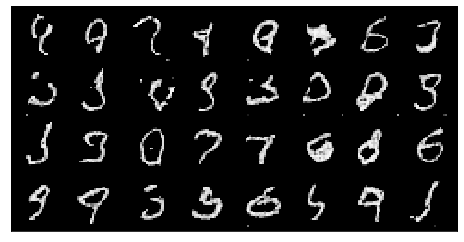

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:36,   G_loss:-0.6297504901885986,   D_loss:9.8915433883667


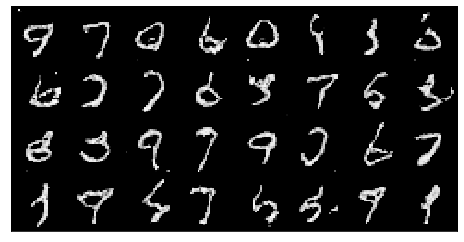

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:37,   G_loss:-0.541511595249176,   D_loss:9.739880561828613


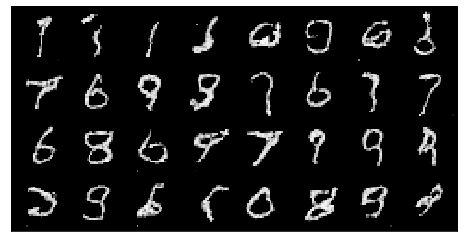

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:38,   G_loss:-0.5677433013916016,   D_loss:9.835994720458984


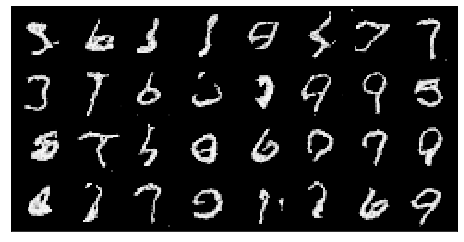

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:39,   G_loss:-0.6092902421951294,   D_loss:9.873193740844727


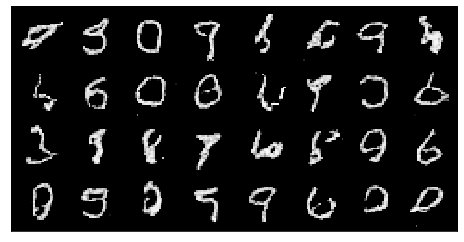

In [12]:
for epoch in range(40):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i,data in enumerate(train_loader):
        
        X, y = data
        #print(X.size())
        X = X.view(X.size(0), 1,28,28)
        X = X.to(DEVICE)
        #print(X.size())
        mb_size = X.size(0)
        #print(mb_size)
        #D(X)
        
        
        # Defining the loss for Discriminator
        z = torch.randn(mb_size, 100)
        z = z.to(DEVICE)
        
        t = torch.rand(mb_size,1,1,1).to(DEVICE)
        X_p = t*X + (1-t)*G(z)
        D_p = D(X_p)
        Xp_grad = torch.autograd.grad(outputs=D_p,inputs=X_p,grad_outputs=torch.ones([mb_size,1]).to(DEVICE))
        gp = 10 * torch.mean(torch.pow(torch.norm(Xp_grad[0],dim=2)-1, exponent=2))
        
        
        #print(D(X).shape)
        X_loss = torch.mean(D(X))
        z_loss = torch.mean(D(G(z)))
        D_loss = z_loss - X_loss + gp
        
        # backward propagation for discriminator
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        # Feed forward for generator
        z = torch.randn(mb_size, 100)
        z = z.to(DEVICE)
        
        # loss function of generator
        G_loss = -torch.mean(D(G(z)))
        
        # backward propagation for generator
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        G_loss_run = G_loss.item()
        D_loss_run = D_loss.item()
        
        
        
    # printing loss after each epoch 
    print('Epoch:{},   G_loss:{},   D_loss:{}'.format(epoch, G_loss_run, D_loss_run ))
    
    # Plotting fake images generated after each epoch by generator
    #print(G(z,y).shape)
    samples = G(z).detach()
    samples = samples.cpu()
    samples = samples.view(samples.size(0), 1, 28, 28)
    imshow(samples)


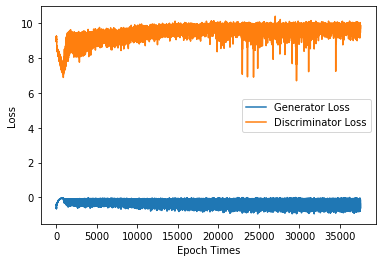

In [13]:
plt.plot(G_losses,label='Generator Loss')
plt.plot(D_losses,label='Discriminator Loss')
plt.legend()
plt.xlabel('Epoch Times')
plt.ylabel('Loss')
plt.show()